In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
import csv
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

### Data Processing

In [2]:
#Get the mean value for each person's title in each class
def see_survived_by_age_train(lst):
    p1 = {}
    p2 = {}
    p3 = {}
    for person in lst:
        if person[5] >= 0:
            tmp = person[3].split('.')
            tmp = tmp[0].split()
            title = tmp[-1]
            if person[2] == 1:
                if title not in p1:
                    p1[title] = []
                p1[title].append(person[5])
            elif person[2] == 2:
                if title not in p2:
                    p2[title] = []
                p2[title].append(person[5])
            else:
                if title not in p3:
                    p3[title] = []
                p3[title].append(person[5])
    for title in p1:
        p1[title] = np.mean(p1[title])
    for title in p2:
        p2[title] = np.mean(p2[title])
    for title in p3:
        p3[title] = np.mean(p3[title])

    return p1, p2, p3

#Set the people with nan age with the mean value of the corresponding title and class
def assign_age_to_unknown_train(lst, p1, p2, p3):
    for person in lst:
        if not person[5] >= 0:
            tmp = person[3].split('.')
            tmp = tmp[0].split()
            title = tmp[-1]
            if person[2] == 1:
                person[5] = p1[title] 
            elif person[2] == 2:
                person[5] = p2[title]
            else:
                person[5] = p3[title]

In [3]:
setloader = np.array(pd.read_csv("train.csv"))
p1, p2, p3 = see_survived_by_age_train(setloader)
assign_age_to_unknown_train(setloader, p1, p2, p3)
setloader = np.delete(setloader, 0, axis=1)
setloader = np.delete(setloader, 2, axis=1)
setloader = np.delete(setloader, 6, axis=1)
setloader = setloader[:, :-2]
setloader[:, 2] = np.where(setloader[:, 2] == "male", 0, 1)
setloader = setloader.astype(float)

# Split the dataset into features (X) and labels (y)
X = setloader[:, 1:]
y = setloader[:, 0]

Load Test Set

In [4]:
#Samething as the train set, we add replace the nan age with the mean of corresponding title and class
#Except the test set also has nan values on the feature fares, so I replaced the nan fares with the same idea
def see_survived_by_age_test(lst):
    p1 = {}
    p2 = {}
    p3 = {}
    for person in lst:
        if person[4] >= 0:
            tmp = person[2].split('.')
            tmp = tmp[0].split()
            title = tmp[-1]
            if person[1] == 1:
                if title not in p1:
                    p1[title] = {}
                    p1[title]["age"] = []
                p1[title]["age"].append(person[4])
            elif person[1] == 2:
                if title not in p2:
                    p2[title] = {}
                    p2[title]["age"] = []
                p2[title]["age"].append(person[4])
            else:
                if title not in p3:
                    p3[title] = {}
                    p3[title]["age"] = []
                p3[title]["age"].append(person[4])
    for person in lst:
        if person[8] >= 0:
            tmp = person[2].split('.')
            tmp = tmp[0].split()
            title = tmp[-1]
            if person[1] == 1:
                if "fare" not in p1[title]:
                    p1[title]["fare"] = []
                p1[title]["fare"].append(person[8])
            elif person[1] == 2:
                if "fare" not in p2[title]:
                    p2[title]["fare"] = []
                p2[title]["fare"].append(person[8])
            else:
                if title not in p3:
                    p3[title] = {}
                if "fare" not in p3[title]:
                    p3[title]["fare"] = []
                p3[title]["fare"].append(person[8])
    for title in p1:
        p1[title]["age"] = np.mean(p1[title]["age"])
        p1[title]["fare"] = np.mean(p1[title]["fare"])
    for title in p2:
        p2[title]["age"] = np.mean(p2[title]["age"])
        p2[title]["fare"] = np.mean(p2[title]["fare"])
    for title in p3:
        p3[title]["fare"] = np.mean(p3[title]["fare"])
        try:
            p3[title]["age"] = np.mean(p3[title]["age"])
        except:
            continue

    return p1, p2, p3

def assign_age_fare_to_unknown_test(lst, p1, p2, p3):
    for person in lst:
        tmp = person[2].split('.')
        tmp = tmp[0].split()
        title = tmp[-1]
        if not person[4] >= 0:
            if person[1] == 1:
                person[4] = p1[title]["age"] 
            elif person[1] == 2:
                person[4] = p2[title]["age"] 
            else:
                try:
                    person[4] = p3[title]["age"] 
                except:
                    person[4] = 28
        if not person[8] >= 0:
            if person[1] == 1:
                person[8] = p1[title]["fare"]
            elif person[1] == 2:
                person[8] = p2[title]["fare"]
            else:
                person[8] = p3[title]["fare"]


In [5]:
testloader = np.array(pd.read_csv("test.csv"))
p1, p2, p3 = see_survived_by_age_test(testloader)
assign_age_fare_to_unknown_test(testloader, p1, p2, p3)
testloader = np.delete(testloader, 0, axis=1)
testloader = np.delete(testloader, 1, axis=1)
testloader = np.delete(testloader, 5, axis=1)
testloader = testloader[:, :-2]
testloader[:, 1] = np.where(testloader[:, 1] == "male", 0, 1)
testloader = testloader.astype(float)

Train,Test Input Features Standard Normalization

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(testloader)

## Model Building and Training

### SVM Kernel

SVM model with rbf

In [7]:
svm_model = svm.SVC(kernel='rbf')

Hyperparameter tuning with 5-fold validation

In [8]:
# svm_model = svm.SVC(kernel='rbf')
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 300]}
# num_folds = 5
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=32)
# grid_search = GridSearchCV(svm_model, param_grid, cv=kf, scoring='accuracy')
# grid_search.fit(X_train, y)
# best_C = grid_search.best_params_['C']
# print(f"Best value for C: {best_C}")

Train with the best hyperparameter 

In [9]:
best_C = 1.0
clf = svm.SVC(C=best_C, kernel='rbf')
clf.fit(X_train, y)
output = clf.predict(X_test)

Output submission file

In [10]:
f = open('submission1.csv', 'w', newline='')
writer = csv.writer(f)
writer.writerow(['PassengerId', 'Survived'])
for i in range(len(output)):
    writer.writerow([892+i, int(output[i])])
f.close()

Final Accuracy for SVM kernel = rbf with Regularization parameter = 1 is 0.77511

## Neural Networks

MLP model

In [11]:
mlp_model = MLPClassifier(max_iter=2000) 

Hyperparameter tuning with 5-fold validation

In [12]:
# mlp_model = MLPClassifier(max_iter=2000) 
# param_grid = {'alpha': [1e-1, 1, 5, 10, 50], 
#               'hidden_layer_sizes': [(32, 16, 8), (16, 8, 4), (32, 16, 4)],
#               'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1]}
# num_folds = 5
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=32)
# grid_search = GridSearchCV(mlp_model, param_grid, cv=kf, scoring='accuracy')
# grid_search.fit(X_train, y)
# best_alpha = grid_search.best_params_['alpha']
# best_hl = grid_search.best_params_['hidden_layer_sizes']
# best_lr = grid_search.best_params_['learning_rate_init']
# print(f"Best value for alpha: {best_alpha}. Best value for learning rate: {best_lr}, Best value for hidden lay size: {best_hl}")

Best value for alpha: 1. Best value for learning rate: 0.001Best value for hidden lay size: (32, 16, 8)


Train with the best hyperparameter 

In [20]:
best_alpha = 1
best_hl = (32, 16, 8)
best_lr = 0.001
clf = MLPClassifier(alpha=best_alpha, hidden_layer_sizes=best_hl, learning_rate_init = best_lr, max_iter=2000)
clf.fit(X_train, y)
output = clf.predict(X_test)

Output submission file

In [21]:
f = open('submission2.csv', 'w', newline='')
writer = csv.writer(f)
writer.writerow(['PassengerId', 'Survived'])
for i in range(len(output)):
    writer.writerow([892+i, int(output[i])])
f.close()

Final Accuracy for Neural Network MLP with alpha = 2, learning rate = 0.0001, hidden size = (32, 16, 8) is 0.77751

## Tree-based

Decision Tree Classifier model

In [22]:
tree_model = DecisionTreeClassifier() 

Hyperparameter tuning with 5-fold validation

In [45]:
# tree_model = DecisionTreeClassifier() 

# param_grid = {
#     'splitter': ['best', 'random'],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10, 15],
#     'min_samples_leaf': [1, 2, 4, 8],
#     'random_state': [8, 16, 32, 64]
# }

# num_folds = 5
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=32)
# grid_search = GridSearchCV(tree_model, param_grid, cv=kf, scoring='accuracy')
# grid_search.fit(X_train, y)

# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 15, 'random_state': 16, 'splitter': 'random'}


Train with the best hyperparameter 

In [46]:
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=15, random_state=16, splitter="random")
clf.fit(X_train, y)
output = clf.predict(X_test)

Output submission file

In [38]:
f = open('submission3.csv', 'w', newline='')
writer = csv.writer(f)
writer.writerow(['PassengerId', 'Survived'])
for i in range(len(output)):
    writer.writerow([892+i, int(output[i])])
f.close()

Final Accuracy for DecisionTreeClassifier with the best parameters is 0.78229

## Results and Performances

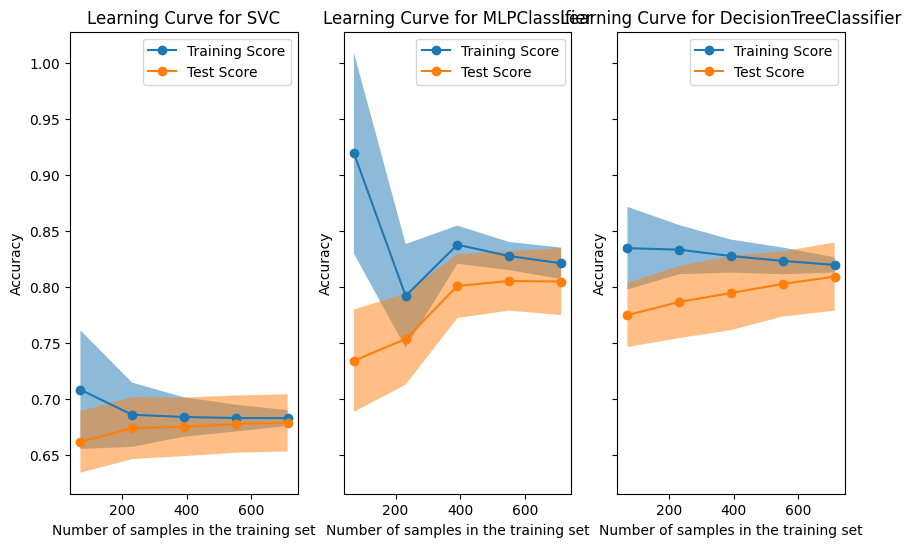

In [41]:
#Reference:https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
svm_model = svm.SVC(kernel='rbf', C=1.0)
mlp_model = MLPClassifier(max_iter=2000, alpha=1.0, learning_rate_init=0.001, hidden_layer_sizes=(32, 16, 8)) 
tree_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=15, random_state=16, splitter="random")

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharey=True)
common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=32),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([svm_model, mlp_model, tree_model]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")